In [1]:
import torch
from torch import nn
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_data = datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [2]:
print(train_data.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [3]:
sample_images, sample_labels = next(iter(train_loader))
print(f'Sample batch shape: {sample_images.shape}')
print(f'Sample labels: {sample_labels}')

Sample batch shape: torch.Size([64, 3, 32, 32])
Sample labels: tensor([7, 0, 7, 3, 9, 6, 9, 6, 5, 9, 8, 6, 8, 3, 6, 4, 5, 9, 8, 8, 7, 5, 4, 0,
        3, 2, 2, 4, 0, 5, 3, 6, 0, 8, 6, 7, 1, 1, 7, 1, 8, 0, 3, 0, 6, 7, 6, 6,
        5, 7, 0, 7, 1, 7, 7, 5, 7, 2, 0, 5, 0, 2, 1, 8])


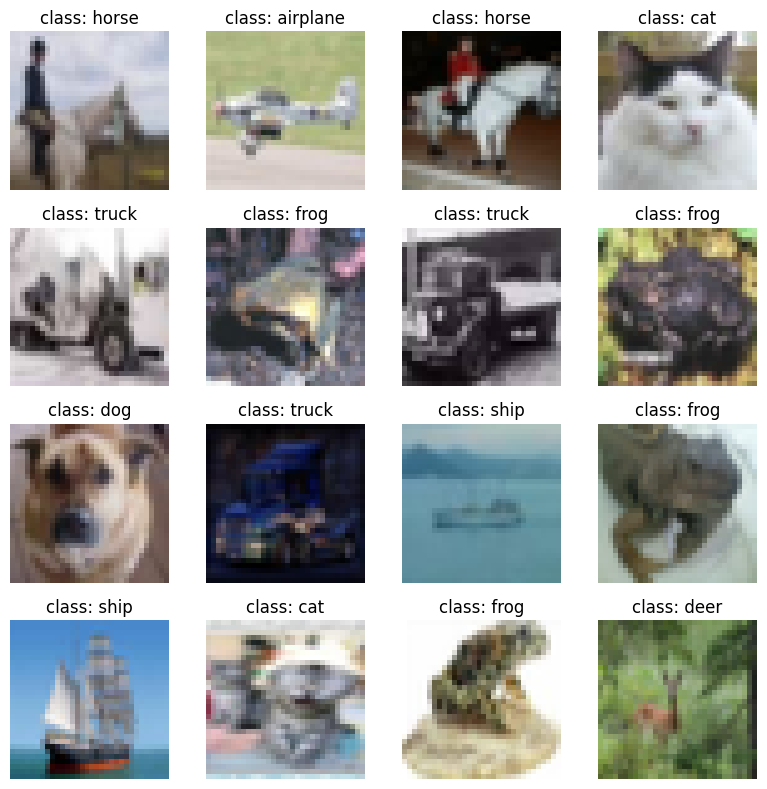

In [6]:
# show batch of images
import matplotlib.pyplot as plt

def show_images(images, labels, class_name):
    _, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            img = images[i].permute(1, 2, 0).numpy()
            ax.imshow(img)
            ax.set_title(f'class: {class_name[labels[i]]}')
            ax.axis('off')
    plt.tight_layout()
    plt.show()
show_images(sample_images[:16], sample_labels[:16], train_data.classes)

In [10]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x))) # 3 * 32 * 32 -> 16 * 16 * 16
        x = self.pool(self.relu(self.conv2(x))) # 16 * 16 * 16 -> 32 * 8 * 8
        x = x.view(-1, 32 * 8 * 8) # flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [31]:
def train(model, dataloader, loss_fn, optimizer):
    model.train()
    for images, labels in dataloader:
        images, labels = images.to('cuda'), labels.to('cuda')

        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def test(epoch_index, model, dataloader):
    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to('cuda'), labels.to('cuda')
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Epoch {epoch_index + 1}, Accuracy: {accuracy:.2f}%')

In [36]:
def check_last_model_performance(model, test_loader):
    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to('cuda'), labels.to('cuda')
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Final Model Accuracy: {accuracy:.2f}%')

def check_learning_parameter(target_model, optimizer, train_dataset, test_dataset, batch_size):
    epochs = 10
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    loss_fn = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        train(target_model, train_loader, loss_fn, optimizer)
        test(epoch, target_model, test_loader)
    check_last_model_performance(target_model, test_loader)

In [37]:
learning_rate_set = [0.1, 0.01, 0.001, 0.0001]
batch_size_set = [16, 32, 64, 128]

for lr in learning_rate_set:
    for bs in batch_size_set:
        model = SimpleCNN().to('cuda')
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        check_learning_parameter(model, optimizer, train_data, test_data, bs)
        print(f'Learning Rate: {lr}, Batch Size: {bs} completed.\n')

Epoch 1, Accuracy: 10.00%
Epoch 2, Accuracy: 10.00%
Epoch 3, Accuracy: 10.00%
Epoch 4, Accuracy: 10.00%
Epoch 5, Accuracy: 10.00%
Epoch 6, Accuracy: 10.00%
Epoch 7, Accuracy: 10.00%
Epoch 8, Accuracy: 10.00%
Epoch 9, Accuracy: 10.00%
Epoch 10, Accuracy: 10.00%
Final Model Accuracy: 10.00%
Learning Rate: 0.1, Batch Size: 16 completed.

Epoch 1, Accuracy: 10.00%
Epoch 2, Accuracy: 10.00%
Epoch 3, Accuracy: 10.00%
Epoch 4, Accuracy: 10.00%
Epoch 5, Accuracy: 10.00%
Epoch 6, Accuracy: 10.00%
Epoch 7, Accuracy: 10.00%
Epoch 8, Accuracy: 10.00%
Epoch 9, Accuracy: 10.00%
Epoch 10, Accuracy: 10.00%
Final Model Accuracy: 10.00%
Learning Rate: 0.1, Batch Size: 32 completed.

Epoch 1, Accuracy: 10.00%
Epoch 2, Accuracy: 10.00%
Epoch 3, Accuracy: 10.00%
Epoch 4, Accuracy: 10.00%
Epoch 5, Accuracy: 10.00%
Epoch 6, Accuracy: 10.00%
Epoch 7, Accuracy: 10.00%
Epoch 8, Accuracy: 10.00%
Epoch 9, Accuracy: 10.00%
Epoch 10, Accuracy: 10.00%
Final Model Accuracy: 10.00%
Learning Rate: 0.1, Batch Size: 64 c

KeyboardInterrupt: 